In [1]:
import re
import seaborn as sns
import pandas as pd
import numpy as np
import typing
import glob
import os

In [2]:
re_events=re.compile(r'^S(\d),1,(\d+),,uncore_cha_(\d+)/event=(.+),umask=(.+)/,\d+,\d+\.\d*,,$')

In [3]:
data = pd.DataFrame()

for file in glob.glob('results/*.out'):
    cpu = int(os.path.splitext(os.path.basename(file))[0])

    for line in open(file).readlines():
        is_event_info = re_events.match(line)
        if not is_event_info:
            continue

        socket = int(is_event_info.group(1))
        value = int(is_event_info.group(2))
        cha_box_id = int(is_event_info.group(3))
        event = is_event_info.group(4)
        umask = is_event_info.group(5)

        data = pd.concat([
            data,
            pd.DataFrame([
                {
                    'cpu': cpu,
                    'socket': socket,
                    'value': value,
                    'cha_box_id': cha_box_id,
                    'event': event,
                    'umask': umask
                }
            ])
        ], ignore_index=True)

data

,cpu,socket,value,cha_box_id,event,umask
0,79,0,3092910,0,144,0x03
1,79,0,568744,0,160,0x03
2,79,0,329489,1,144,0x03
3,79,0,342409,1,160,0x03
4,79,0,37538,2,144,0x03
...,...,...,...,...,...,...
25083,53,1,53510,53,160,0x03
25084,53,1,99601,54,144,0x03
25085,53,1,50763,54,160,0x03
25086,53,1,178697,55,144,0x03


In [4]:
# find cbos for each cpu. we check that with 144, which should increase at the cbo that belongs to the active core
# check vertical mesh egress

# TxR_VERT_OCCUPANCY0
# • Title:
# • Category: Vertical Egress Events
# • Event Code: 0x90
# • Register Restrictions :
# • Definition: Occupancy event for the egress buffers in the common mesh stop. The
#   egress is used to queue up requests destined for the vertical ring on the mesh.

TxR_VERT_OCCUPANCY0 = data[data['event'] == '144']
TxR_VERT_OCCUPANCY0

,cpu,socket,value,cha_box_id,event,umask
0,79,0,3092910,0,144,0x03
2,79,0,329489,1,144,0x03
4,79,0,37538,2,144,0x03
6,79,0,40278,3,144,0x03
8,79,0,22179,4,144,0x03
...,...,...,...,...,...,...
25078,53,1,26972,51,144,0x03
25080,53,1,28934,52,144,0x03
25082,53,1,30500,53,144,0x03
25084,53,1,99601,54,144,0x03


/tmp/ipykernel_219063/3586764365.py:1: UserWarning: 
The palette list has fewer values (10) than needed (112) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=TxR_VERT_OCCUPANCY0, x='cha_box_id', y='value', hue='cpu', legend='full', size='socket', palette=sns.color_palette())


<Axes: xlabel='cha_box_id', ylabel='value'>

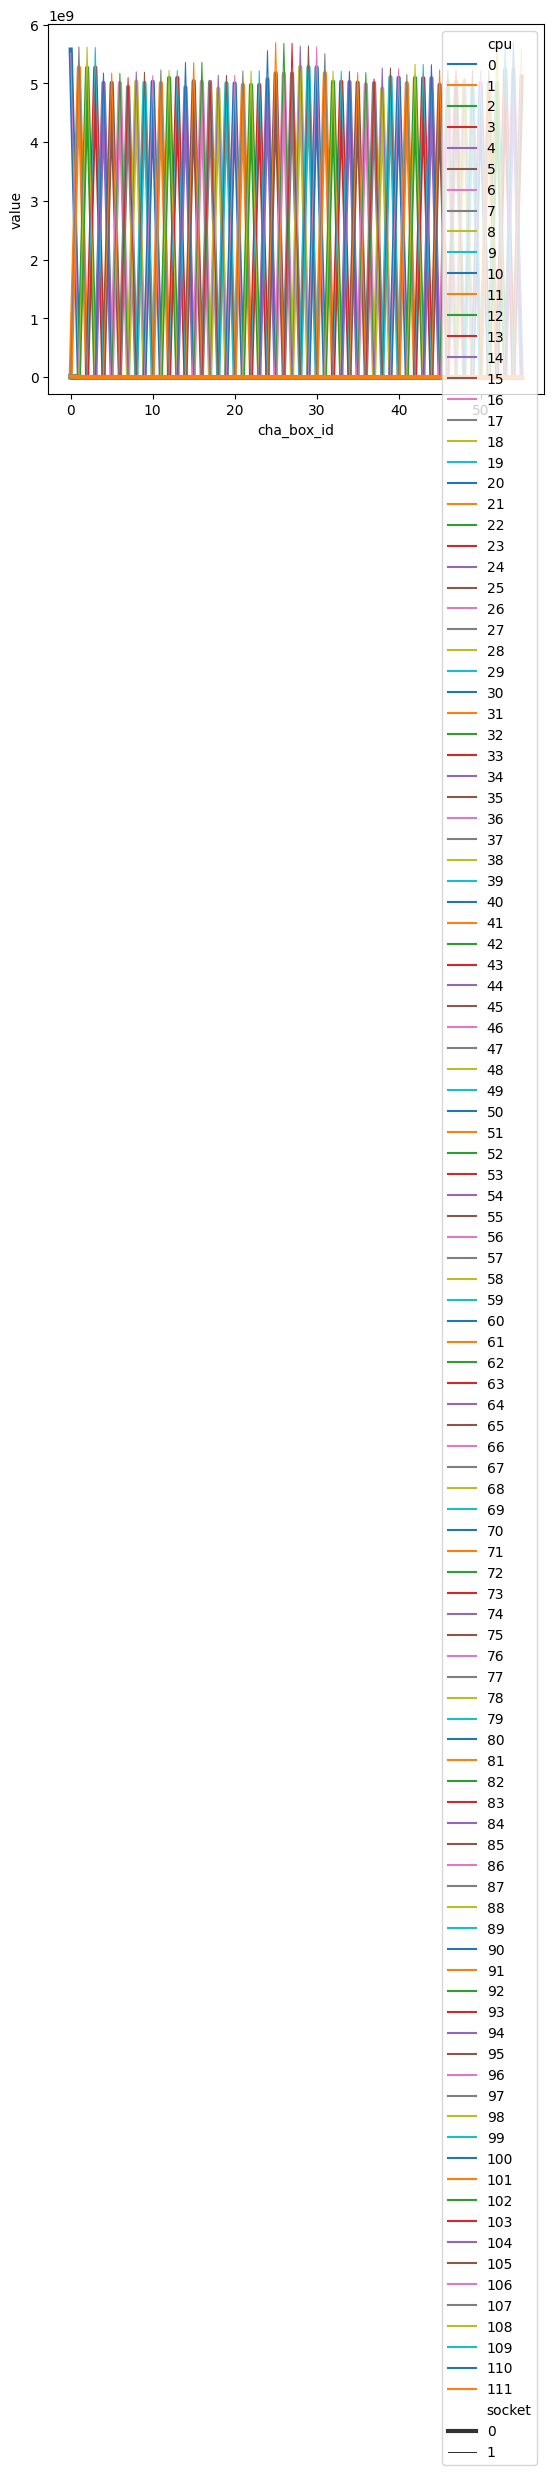

In [5]:
sns.lineplot(data=TxR_VERT_OCCUPANCY0, x='cha_box_id', y='value', hue='cpu', legend='full', size='socket', palette=sns.color_palette())

In [6]:

# TxR_HORZ_OCCUPANCY
# • Title:
# • Category: Horizontal Egress Events
# • Event Code: 0xA0
# • Register Restrictions :
# • Definition: Occupancy event for the transgress buffers in the common mesh stop.
#   The egress is used to queue up requests destined for the horizontal ring on the mesh.

TxR_HORZ_OCCUPANCY = data[data['event'] == '160']
TxR_HORZ_OCCUPANCY

,cpu,socket,value,cha_box_id,event,umask
1,79,0,568744,0,160,0x03
3,79,0,342409,1,160,0x03
5,79,0,62611,2,160,0x03
7,79,0,90474,3,160,0x03
9,79,0,247752,4,160,0x03
...,...,...,...,...,...,...
25079,53,1,43420,51,160,0x03
25081,53,1,28968,52,160,0x03
25083,53,1,53510,53,160,0x03
25085,53,1,50763,54,160,0x03


/tmp/ipykernel_219063/1106596566.py:1: UserWarning: 
The palette list has fewer values (10) than needed (112) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=TxR_HORZ_OCCUPANCY, x='cha_box_id', y='value', hue='cpu', legend='full', size='socket', palette=sns.color_palette())


<Axes: xlabel='cha_box_id', ylabel='value'>

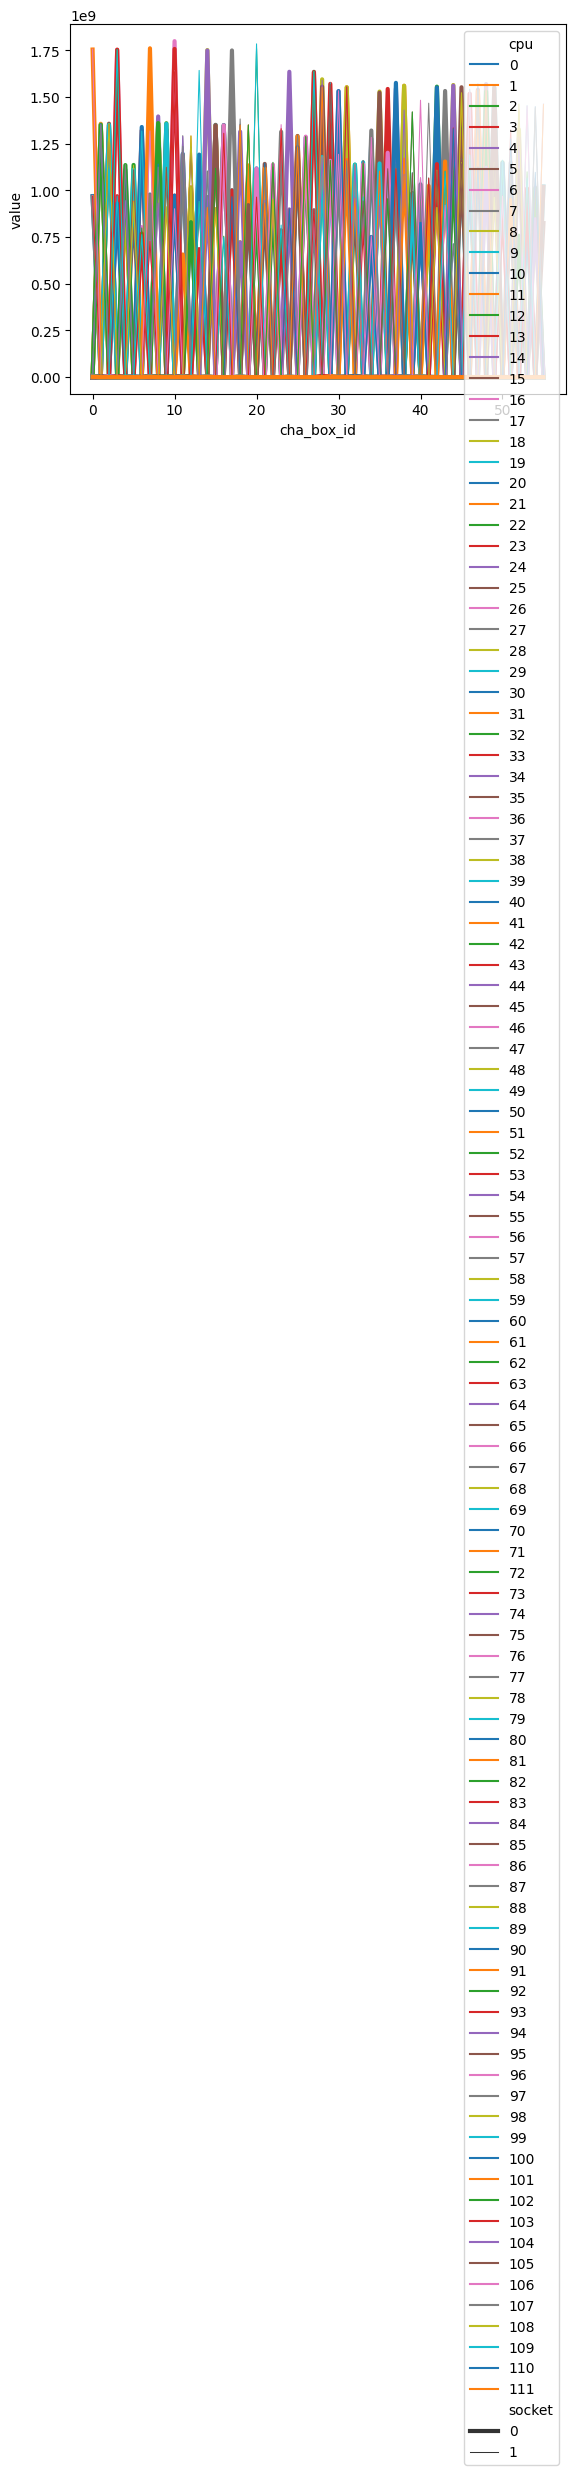

In [7]:
sns.lineplot(data=TxR_HORZ_OCCUPANCY, x='cha_box_id', y='value', hue='cpu', legend='full', size='socket', palette=sns.color_palette())

In [8]:
# find CHA for each cpu. we check that with TxR_VERT_OCCUPANCY0/0x3, which should increase at the cbo that belongs to the active core
# \arg socket: the socket for which to get the mapping
def get_cha_to_cpu_map(socket: int) -> dict:
    TxR_VERT_OCCUPANCY0 = data[data['event'] == '144']
    TxR_VERT_OCCUPANCY0 = TxR_VERT_OCCUPANCY0[TxR_VERT_OCCUPANCY0['umask'] == '0x03']
    TxR_VERT_OCCUPANCY0 = TxR_VERT_OCCUPANCY0[TxR_VERT_OCCUPANCY0['socket'] == socket]

    cha_to_cpu_map = dict()

    for cha_box in TxR_VERT_OCCUPANCY0['cha_box_id'].unique():
        values = TxR_VERT_OCCUPANCY0[TxR_VERT_OCCUPANCY0['cha_box_id'] == cha_box]
        max_index = values['value'].idxmax()
        loc = TxR_VERT_OCCUPANCY0.loc[max_index]
        if loc['value'] > 2.0E8:
            cha_to_cpu_map[cha_box] = loc['cpu']

    return cha_to_cpu_map

In [9]:
get_cha_to_cpu_map(0)

{np.int64(0): np.int64(0),
 np.int64(1): np.int64(1),
 np.int64(2): np.int64(2),
 np.int64(3): np.int64(3),
 np.int64(4): np.int64(4),
 np.int64(5): np.int64(5),
 np.int64(6): np.int64(6),
 np.int64(7): np.int64(7),
 np.int64(8): np.int64(8),
 np.int64(9): np.int64(9),
 np.int64(10): np.int64(10),
 np.int64(11): np.int64(11),
 np.int64(12): np.int64(12),
 np.int64(13): np.int64(13),
 np.int64(14): np.int64(14),
 np.int64(15): np.int64(15),
 np.int64(16): np.int64(16),
 np.int64(17): np.int64(17),
 np.int64(18): np.int64(18),
 np.int64(19): np.int64(19),
 np.int64(20): np.int64(20),
 np.int64(21): np.int64(21),
 np.int64(22): np.int64(22),
 np.int64(23): np.int64(23),
 np.int64(24): np.int64(24),
 np.int64(25): np.int64(25),
 np.int64(26): np.int64(26),
 np.int64(27): np.int64(27),
 np.int64(28): np.int64(28),
 np.int64(29): np.int64(29),
 np.int64(30): np.int64(30),
 np.int64(31): np.int64(31),
 np.int64(32): np.int64(32),
 np.int64(33): np.int64(33),
 np.int64(34): np.int64(34),
 np.i

In [10]:
# TxR_HORZ_OCCUPANCY
# • Title:
# • Category: Horizontal Egress Events
# • Event Code: 0xA0
# • Register Restrictions :
# • Definition: Occupancy event for the transgress buffers in the common mesh stop.
#   The egress is used to queue up requests destined for the horizontal ring on the mesh.

# AD (Address) - Uncredited and AK (Aknowledge)

# Find the CHA boxes of each row for a specified socket. The resulting rows will not be ordered.
# \arg socket: the socket for which to get the rows of CHA boxes
def get_cha_rows(socket: int) -> typing.List[typing.Set[np.int64]]:
    TxR_HORZ_OCCUPANCY = data[data['event'] == '160']
    TxR_HORZ_OCCUPANCY = TxR_HORZ_OCCUPANCY[TxR_HORZ_OCCUPANCY['umask'] == '0x03']
    TxR_HORZ_OCCUPANCY = TxR_HORZ_OCCUPANCY[TxR_HORZ_OCCUPANCY['socket'] == socket]
    TxR_HORZ_OCCUPANCY = TxR_HORZ_OCCUPANCY[TxR_HORZ_OCCUPANCY['value'] > 2.0E8]

    rows = list()

    for cpu in TxR_HORZ_OCCUPANCY['cpu'].unique():
        row_values = TxR_HORZ_OCCUPANCY[TxR_HORZ_OCCUPANCY['cpu'] == cpu]
        row = set(row_values['cha_box_id'])
        if row not in rows:
            rows.append(row)

    return rows

In [11]:
get_cha_rows(0)

[{31, 38, 41},
 {3, 6, 10, 13},
 {45, 49, 55},
 {2, 5, 9},
 {16, 20, 22, 26},
 {17, 23, 27},
 {44, 48, 52, 54},
 {1, 4, 8, 12},
 {30, 34, 37, 40},
 {15, 19, 21, 25},
 {28, 32, 35, 39},
 {14, 18, 24},
 {43, 47, 51},
 {29, 33, 36},
 {42, 46, 50, 53},
 {0, 7, 11}]

In [12]:
# We assume that CHA boxes are numbered in a manner that each tile can be described by a range of CHA boxes.
# This means that the minimum cha box index of the second tile is bigger than the maximum cha box index of the first tile
# Get the rows that belong to a tile by looping over the rows of the tile and discovering new rows by incresing the index by which cha boxes are found.
# \arg rows: all rows of a socket
# \arg min_find_index: the index where to start searching for rows that belong to one tile.
def get_rows_of_tile(rows: typing.List[typing.Set[np.int64]], min_find_index: int) -> typing.List[typing.Set[np.int64]]:
    current_find_index = min_find_index
    filtered_rows = list()

    # Repeat four times since we a looking to find four rows
    for _i in range(4):
        for row in rows:
            if min_find_index <= min(row) <= current_find_index:
                if row not in filtered_rows:
                    filtered_rows.append(row)
                    current_find_index = max(row)

    return filtered_rows


In [13]:
# Get the rows of the first tile of socket 0
get_rows_of_tile(get_cha_rows(0), 0)

[{0, 7, 11}, {3, 6, 10, 13}, {2, 5, 9}, {1, 4, 8, 12}]

In [14]:
# Split the rows of chas into a list of tiles that each contains a list of rows with chas
# \arg cha_rows: The list of CHA boxes split into rows
def get_tiled_cha_rows(cha_rows: typing.List[typing.Set[np.int64]]) -> typing.List[typing.List[typing.Set[np.int64]]]:
    tiled_cha_rows = list()
    index = 0
    while index == 0 or len(rows) > 0:
        rows = get_rows_of_tile(get_cha_rows(0), index)
        if len(rows) == 0:
            break
        index = max(map(max, rows)) + 1
        tiled_cha_rows.append(rows)

    return tiled_cha_rows

In [15]:
# Print the list of all CHA boxes in rows for each tiles of socket 0
for tile in get_tiled_cha_rows(get_cha_rows(0)):
    print(tile)

[{0, 11, 7}, {10, 3, 13, 6}, {9, 2, 5}, {8, 1, 4, 12}]
[{24, 18, 14}, {16, 26, 20, 22}, {17, 27, 23}, {25, 19, 21, 15}]
[{32, 35, 28, 39}, {33, 36, 29}, {41, 38, 31}, {40, 34, 37, 30}]
[{42, 50, 53, 46}, {49, 45, 55}, {48, 54, 44, 52}, {51, 43, 47}]


In [16]:
def print_tile(cha_matrix: typing.List[typing.List[np.int64]], tile_index: int, cha_to_cpu_map: dict) -> typing.NoReturn:
    for row_index, row in enumerate(cha_matrix):
        for column_index, column in enumerate(row):
            if column == -1:
                # Fill missing spaces with X
                cha_matrix[row_index][column_index] = "X"
            else:
                # Fill CHAs with CPUs
                if column in cha_to_cpu_map:
                    cha_matrix[row_index][column_index] = f"CHA: {column} CPU: {cha_to_cpu_map[column]}"
                else:
                    cha_matrix[row_index][column_index] = f"CHA: {column}"

    # Fill missing memory controllers
    if tile_index == 0:
        cha_matrix[0][1] = "M"
    elif tile_index == 1:
        cha_matrix[0][2] = "M"
    elif tile_index == 2:
        cha_matrix[3][1] = "M"
    elif tile_index == 3:
        cha_matrix[3][2] = "M"
    else:
        assert("Tile indices bigger that 3 are not valid")

    for row in cha_matrix:
        print(row)

In [17]:
for socket in data['socket'].unique():
    cha_rows = get_cha_rows(socket)
    tiled_cha_rows = get_tiled_cha_rows(cha_rows)

    all_tiles = list()

    for tile_cha_rows in tiled_cha_rows:
        tile_cha_rows = sorted(list(map(lambda row: sorted(list(row)), tile_cha_rows)))

        # Each tile is a 4x4 matrix with the physical locations
        tile = list()
        for i in range(4):
            tile.append(4 * [ -1 ])

        # the index of the last row with four entries
        last_full_row_index = -1
        # emplace rows with all four entries into the tile matrix
        for index, row in enumerate(tile_cha_rows):
            if len(row) != 4:
                continue

            tile[index] = row
            last_full_row_index = index

        if last_full_row_index == -1:
            assert("We did not find any rows with four elements in the current tile!")

        print(f"Socket {socket}, Tile filed only with rows that contain all (four) CHA boxes")
        print(tile)

        # emplace rows that do not contain all four entries.
        # this code is quite hacky, especially the detection of the placing of the rows relative to the last full row.
        # it should ideally be replaced by an ILP formulation.
        for index, row in enumerate(tile_cha_rows):
            if len(row) == 4:
                continue

            if index < last_full_row_index:
                for current_row_column_index in range(len(row)):
                    for absolute_column_index in range(4):
                        if row[current_row_column_index] < tile[last_full_row_index][absolute_column_index]:
                            tile[index][absolute_column_index] = row[current_row_column_index]
                            break

            if index > last_full_row_index:
                for current_row_column_index in reversed(range(len(row))):
                    for absolute_column_index in range(4):
                        if row[current_row_column_index] > tile_cha_rows[last_full_row_index][absolute_column_index]:
                            tile[index][absolute_column_index] = row[current_row_column_index]

                            # If the entry was emplaced into the previous column, keep the current and delete the last
                            if absolute_column_index > 0 and tile[index][absolute_column_index] == tile[index][absolute_column_index-1]:
                                tile[index][absolute_column_index-1] = -1

        print(tile)
        all_tiles.append(tile)

    for tile_index, tile in enumerate(all_tiles):
        print(f"Tile {tile_index} of socket {socket}:")
        print_tile(tile, tile_index, get_cha_to_cpu_map(socket))

Socket 0, Tile filed only with rows that contain all (four) CHA boxes
[[-1, -1, -1, -1], [1, 4, 8, 12], [-1, -1, -1, -1], [3, 6, 10, 13]]
[[0, -1, 7, 11], [1, 4, 8, 12], [2, 5, 9, -1], [3, 6, 10, 13]]
Socket 0, Tile filed only with rows that contain all (four) CHA boxes
[[-1, -1, -1, -1], [15, 19, 21, 25], [16, 20, 22, 26], [-1, -1, -1, -1]]
[[14, 18, -1, 24], [15, 19, 21, 25], [16, 20, 22, 26], [17, -1, 23, 27]]
Socket 0, Tile filed only with rows that contain all (four) CHA boxes
[[28, 32, 35, 39], [-1, -1, -1, -1], [30, 34, 37, 40], [-1, -1, -1, -1]]
[[28, 32, 35, 39], [29, 33, 36, -1], [30, 34, 37, 40], [31, -1, 38, 41]]
Socket 0, Tile filed only with rows that contain all (four) CHA boxes
[[42, 46, 50, 53], [-1, -1, -1, -1], [44, 48, 52, 54], [-1, -1, -1, -1]]
[[42, 46, 50, 53], [43, 47, 51, -1], [44, 48, 52, 54], [45, 49, -1, 55]]
Tile 0 of socket 0:
['CHA: 0 CPU: 0', 'M', 'CHA: 7 CPU: 7', 'CHA: 11 CPU: 11']
['CHA: 1 CPU: 1', 'CHA: 4 CPU: 4', 'CHA: 8 CPU: 8', 'CHA: 12 CPU: 12']
[